In [1]:
from sklearn.pipeline import Pipeline
from transformers import \
    ColumnTransformer, ColumnClipper, ColumnBinner, ColumnDropper, \
    OneHotEncoder, ModelImputer
import numpy as np
from lightgbm.sklearn import LGBMClassifier

def calculate_reg_01(X):
    return (X.ps_reg_01 * 10).astype('int')

def calculate_reg_02(X):
    return (X.ps_reg_02 * 10).astype('int')

def calculate_reg_04(X):
    return (((X.ps_reg_03.replace(-1, np.NaN) * 40) ** 2) % 27).fillna(-1).astype('int')

def calculate_reg_05(X):
    return (((X.ps_reg_03.replace(-1, np.NaN) * 40) ** 2) // 27).fillna(-1).astype('int')

def calculate_car_12(X):
    return ((X.ps_car_12 ** 2) * 10000).round().astype('int')

def calculate_car_13(X):
    return ((X.ps_car_13 * 220) ** 2).round(2).astype('int')

def calculate_car_14(X):
    return ((X.ps_car_14.replace(-1, np.NaN) ** 2) * 1000).round().fillna(-1).astype('int')

def calculate_car_15(X):
    return (X.ps_car_15 ** 2).astype('int')

def calculate_06_09_cat(X):
    col = X.ps_ind_06_bin * 1 + X.ps_ind_07_bin * 2 + X.ps_ind_08_bin * 3 + X.ps_ind_09_bin * 4
    return col - col.min()

def calculate_16_18_cat(X):
    col = X.ps_ind_16_bin * 1 + X.ps_ind_17_bin * 2 + X.ps_ind_18_bin * 3
    return col - col.min()

pipeline = Pipeline([
    ('calc_reg_01', ColumnTransformer('ps_reg_01', calculate_reg_01)),
    ('calc_reg_02', ColumnTransformer('ps_reg_02', calculate_reg_02)),
    ('calc_reg_04', ColumnTransformer('ps_reg_04', calculate_reg_04)),
    ('calc_reg_05', ColumnTransformer('ps_reg_05', calculate_reg_05)),
    ('calc_car_12', ColumnTransformer('ps_car_12', calculate_car_12)),
    ('calc_car_13', ColumnTransformer('ps_car_13', calculate_car_13)),
    ('calc_car_14', ColumnTransformer('ps_car_14', calculate_car_14)),
    ('calc_car_15', ColumnTransformer('ps_car_15', calculate_car_15)),
    ('calc_car_06_09_cat', ColumnTransformer('ps_car_06_09_cat', calculate_06_09_cat)),
    ('calc_car_16_18_cat', ColumnTransformer('ps_car_16_18_cat', calculate_16_18_cat)),
    ('clip_car_12', ColumnClipper('ps_car_12', 1, 99.9)),
    ('clip_car_13', ColumnClipper('ps_car_13', 1, 99.9)),
    ('drop', ColumnDropper([
        'id', 'ps_ind_14', 'ps_reg_03', 'ps_reg_05',
        'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin',
        'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin'
    ])),
    ('impute_car_11', ModelImputer('ps_car_11', -1, lambda: LGBMClassifier())),
    ('bin_car_12', ColumnBinner('ps_car_12')),
    ('bin_car_13', ColumnBinner('ps_car_13')),
    ('bin_car_14', ColumnBinner('ps_car_14')),
    ('one_hot_encode', OneHotEncoder())
])

In [2]:
import pandas as pd
train = pd.read_csv('./data/train.csv')
holdout = pd.read_csv('./data/holdout.csv')
train = pd.concat([train, holdout])
%time prepared_train = pipeline.fit_transform(train.drop('target', axis=1))

/Users/alexander/Work/datascience/kaggle-port-seguro/transformers.py:84: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  X[column] = X[column].astype('object').astype('category', categories=self.category_mapping[column])


CPU times: user 15.5 s, sys: 4.96 s, total: 20.5 s
Wall time: 13.4 s


In [4]:
import h2o
import numpy as np
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.frame import H2OFrame
h2o.init()
glm_train = prepared_train.copy()
glm_train['target'] = train.target
glm_train = H2OFrame(python_obj=glm_train.to_dict('list'))

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 hour 14 mins
H2O cluster version:,3.15.0.4112
H2O cluster version age:,3 days
H2O cluster name:,alexander
H2O cluster total nodes:,1
H2O cluster free memory:,1.442 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


Parse progress: |█████████████████████████████████████████████████████████| 100%


glm Model Build progress: |███████████████████████████████████████████████| 100%


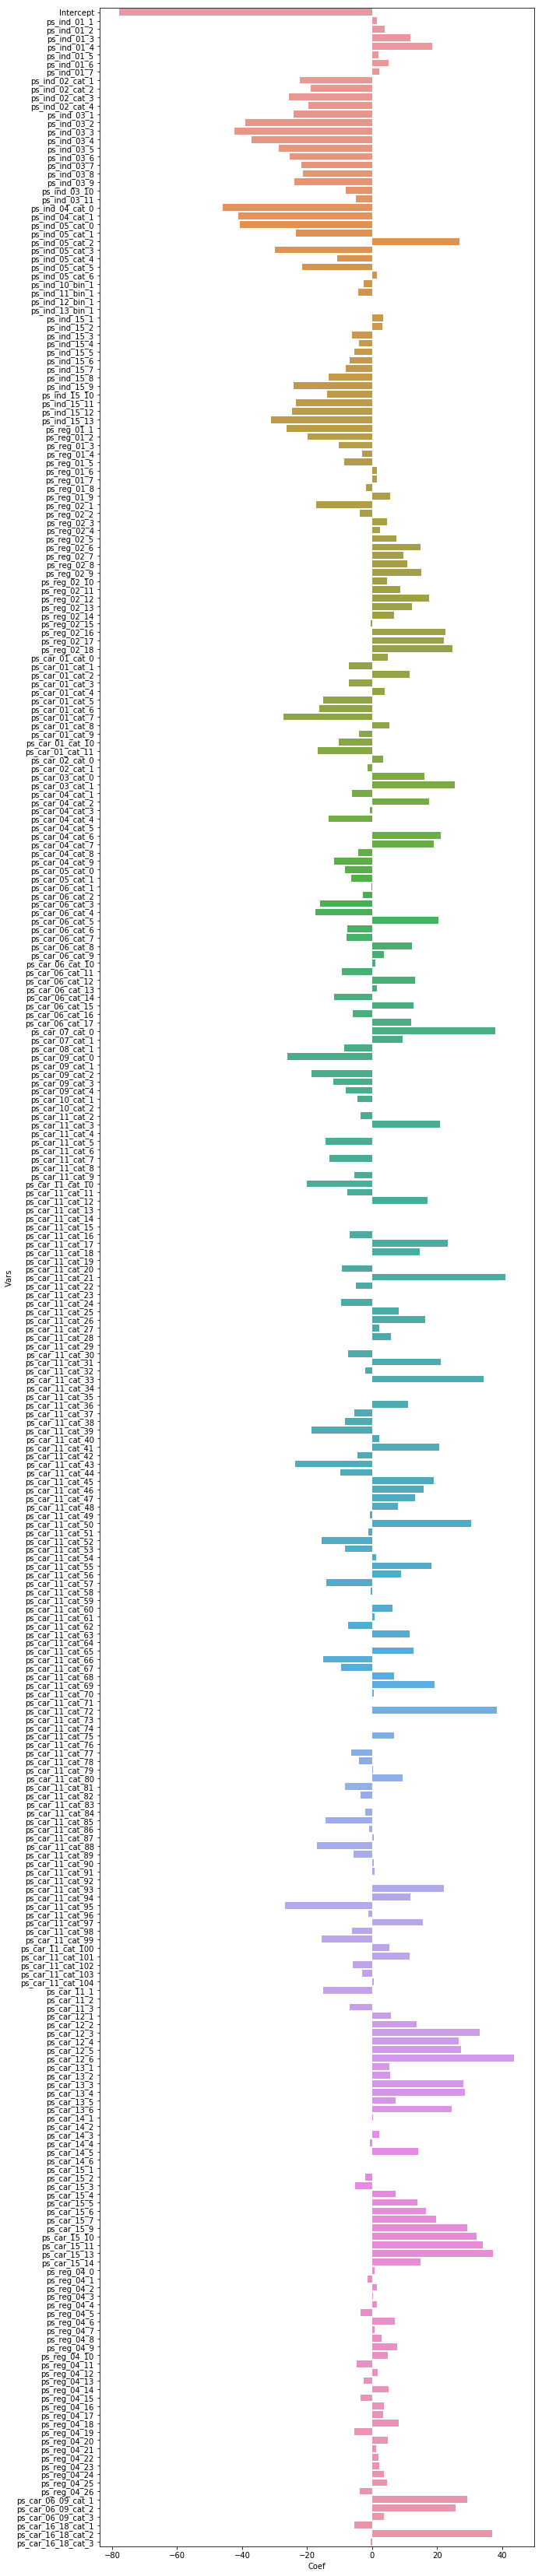

In [5]:
model = H2OGeneralizedLinearEstimator(
    family='binomial',
    standardize=False
)

model.train(
    x=list(set(glm_train.columns) - set(['target'])),
    y='target',
    training_frame=glm_train
)

dic = model.coef()
df = pd.DataFrame()
df['Vars'] = dic.keys()
df['Coef'] = (np.exp(list(dic.values())) - 1) * 100

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x='Coef', y='Vars', data=df, ax=plt.subplots(figsize=(10, 60))[1])

In [8]:
from sklearn.metrics import roc_auc_score
predictions = model.predict(glm_train)
pred = predictions.as_data_frame().p1
actual = glm_train['target'].as_data_frame()
print(roc_auc_score(actual, pred) * 2 - 1)

glm prediction progress: |████████████████████████████████████████████████| 100%
0.284924836874


In [9]:
test = pd.read_csv('./data/test.csv')
ids = test.id
glm_test = pipeline.transform(test)
glm_test = H2OFrame(python_obj=glm_test.to_dict('list'))
glm_test['target'] = H2OFrame(np.round(np.random.uniform(size=len(glm_test))))
test_predictions = model.predict(glm_test)
pred = test_predictions.as_data_frame().p1
submission = pd.DataFrame()
submission['id'] = ids.values
submission['target'] = pred.values
submission.to_csv('./data/submission.csv', index=False)

/Users/alexander/Work/datascience/kaggle-port-seguro/transformers.py:84: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  X[column] = X[column].astype('object').astype('category', categories=self.category_mapping[column])


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
